In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [11]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 8x8x16, output_size = 6x6x16, RF = 18x18
                
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x16, RF = 38x38
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38 

        self.output = nn.Sequential(
            nn.Linear(32,10)
        ) # input_size = 1x1x16, output_size = 1x1x10, RF = 38x38 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 32)
        x = self.output(x)

        return F.log_softmax(x, dim=-1)

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
    

In [13]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

def set_device():
    """set device as with/without cuda based on availability

    Returns:
        string: returns "cuda" f cuda is available else "cpu"
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    return device

##################### Visualtion Utilities #########################

def view_data(data_loader):
    """Gives a visualization of sample data taken from the pytorch data loader

    Args:
        data_loader (torch.utils.data.DataLoader): Wraps an iterable around the Dataset to enable easy access to the samples.
    """
    batch_data, batch_label = next(iter(data_loader)) 
    fig = plt.figure()

    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(batch_data[i].squeeze(0), cmap='gray')
        plt.title(batch_label[i].item())
        plt.xticks([])
        plt.yticks([])


def vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc):
    """Creates graphs for Training Loss and Accuracy, Test Loss and Accuracy.

    Args:
        train_losses (list): training loss
        train_acc (list): training accuracy
        test_losses (list): test loss
        test_acc (list): test accuracy
    """
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

###################### Train and Test Functionalities #####################

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
    """Counts the number of correct predictions made, i.e. prediction=ground truth

    Args:
        pPrediction (tensor): prediction made by the model
        pLabels (tensor): ground truth

    Returns:
        int: count of correct predictions
    """
    return pPrediction.argmax(dim=1, keepdim=True).eq(pLabels.view_as(pPrediction.argmax(dim=1, keepdim=True))).sum().item()

def train(model, device, train_loader, optimizer, train_acc, train_losses):
    """Trains the model

    Args:
        model (torch.nn.Module): pytorch model
        device (_type_): cuda or cpu
        train_loader (torch.utils.data.DataLoader): data iterator on training data
        optimizer (torch.optim): optimizer function
        train_acc (list): stores accuracy of each batch
        train_losses (list): stores loss of each batch
    """
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = F.nll_loss(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, test_acc, test_losses):
    """_summary_

    Args:
        model (torch.nn.Module): pytorch model
        device (_type_): cuda or cpu
        test_loader (torch.utils.data.DataLoader): data iterator on test data
        test_acc (list): stores accuracy of each batch
        test_losses (list): stores loss of each batch
    """
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [15]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  test(model, device, test_loader, test_acc, test_losses)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3845 Batch_id=937 Accuracy=80.10: 100%|██████████| 938/938 [00:39<00:00, 23.63it/s]


Test set: Average loss: 0.0605, Accuracy: 9807/10000 (98.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1039 Batch_id=937 Accuracy=95.97: 100%|██████████| 938/938 [00:31<00:00, 30.12it/s]


Test set: Average loss: 0.0582, Accuracy: 9806/10000 (98.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.3055 Batch_id=937 Accuracy=96.72: 100%|██████████| 938/938 [00:31<00:00, 29.44it/s]


Test set: Average loss: 0.0334, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0642 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [00:33<00:00, 28.37it/s]


Test set: Average loss: 0.0316, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0445 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:31<00:00, 29.76it/s]


Test set: Average loss: 0.0306, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.2260 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:31<00:00, 30.21it/s]


Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1017 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:31<00:00, 29.83it/s]


Test set: Average loss: 0.0261, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0116 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:32<00:00, 29.27it/s]


Test set: Average loss: 0.0247, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0053 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:31<00:00, 29.97it/s]


Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1205 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:31<00:00, 30.02it/s]


Test set: Average loss: 0.0205, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.1305 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:31<00:00, 29.66it/s]


Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.1472 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:31<00:00, 29.53it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.1252 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:31<00:00, 30.06it/s]


Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.0487 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:32<00:00, 29.13it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0031 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:31<00:00, 29.94it/s]


Test set: Average loss: 0.0178, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0247 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:31<00:00, 29.47it/s]


Test set: Average loss: 0.0195, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0082 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:31<00:00, 29.69it/s]


Test set: Average loss: 0.0179, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0014 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:31<00:00, 30.16it/s]


Test set: Average loss: 0.0189, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0914 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:32<00:00, 29.14it/s]


Test set: Average loss: 0.0177, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0597 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:31<00:00, 29.40it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-04.


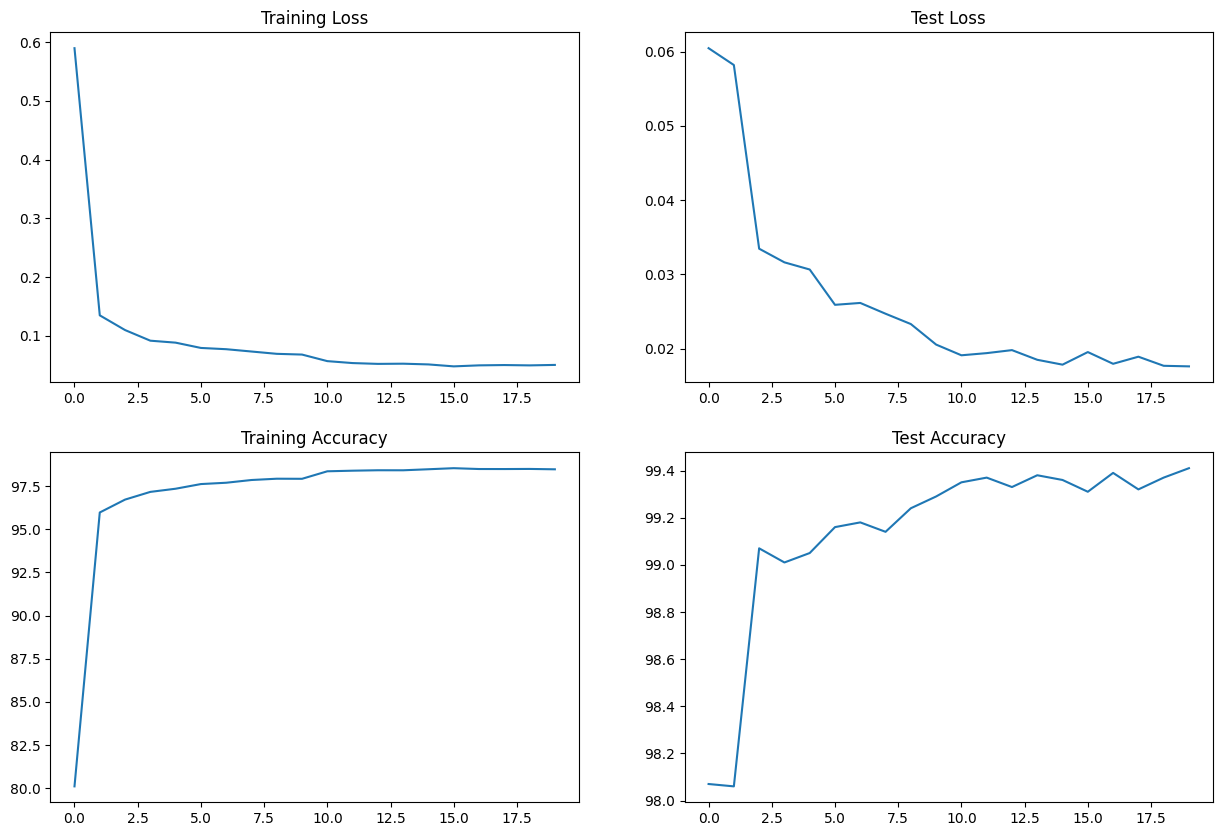

In [16]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [17]:
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-zq7pn2vy
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-zq7pn2vy
  Resolved https://github.com/szagoruyko/pytorchviz.git to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


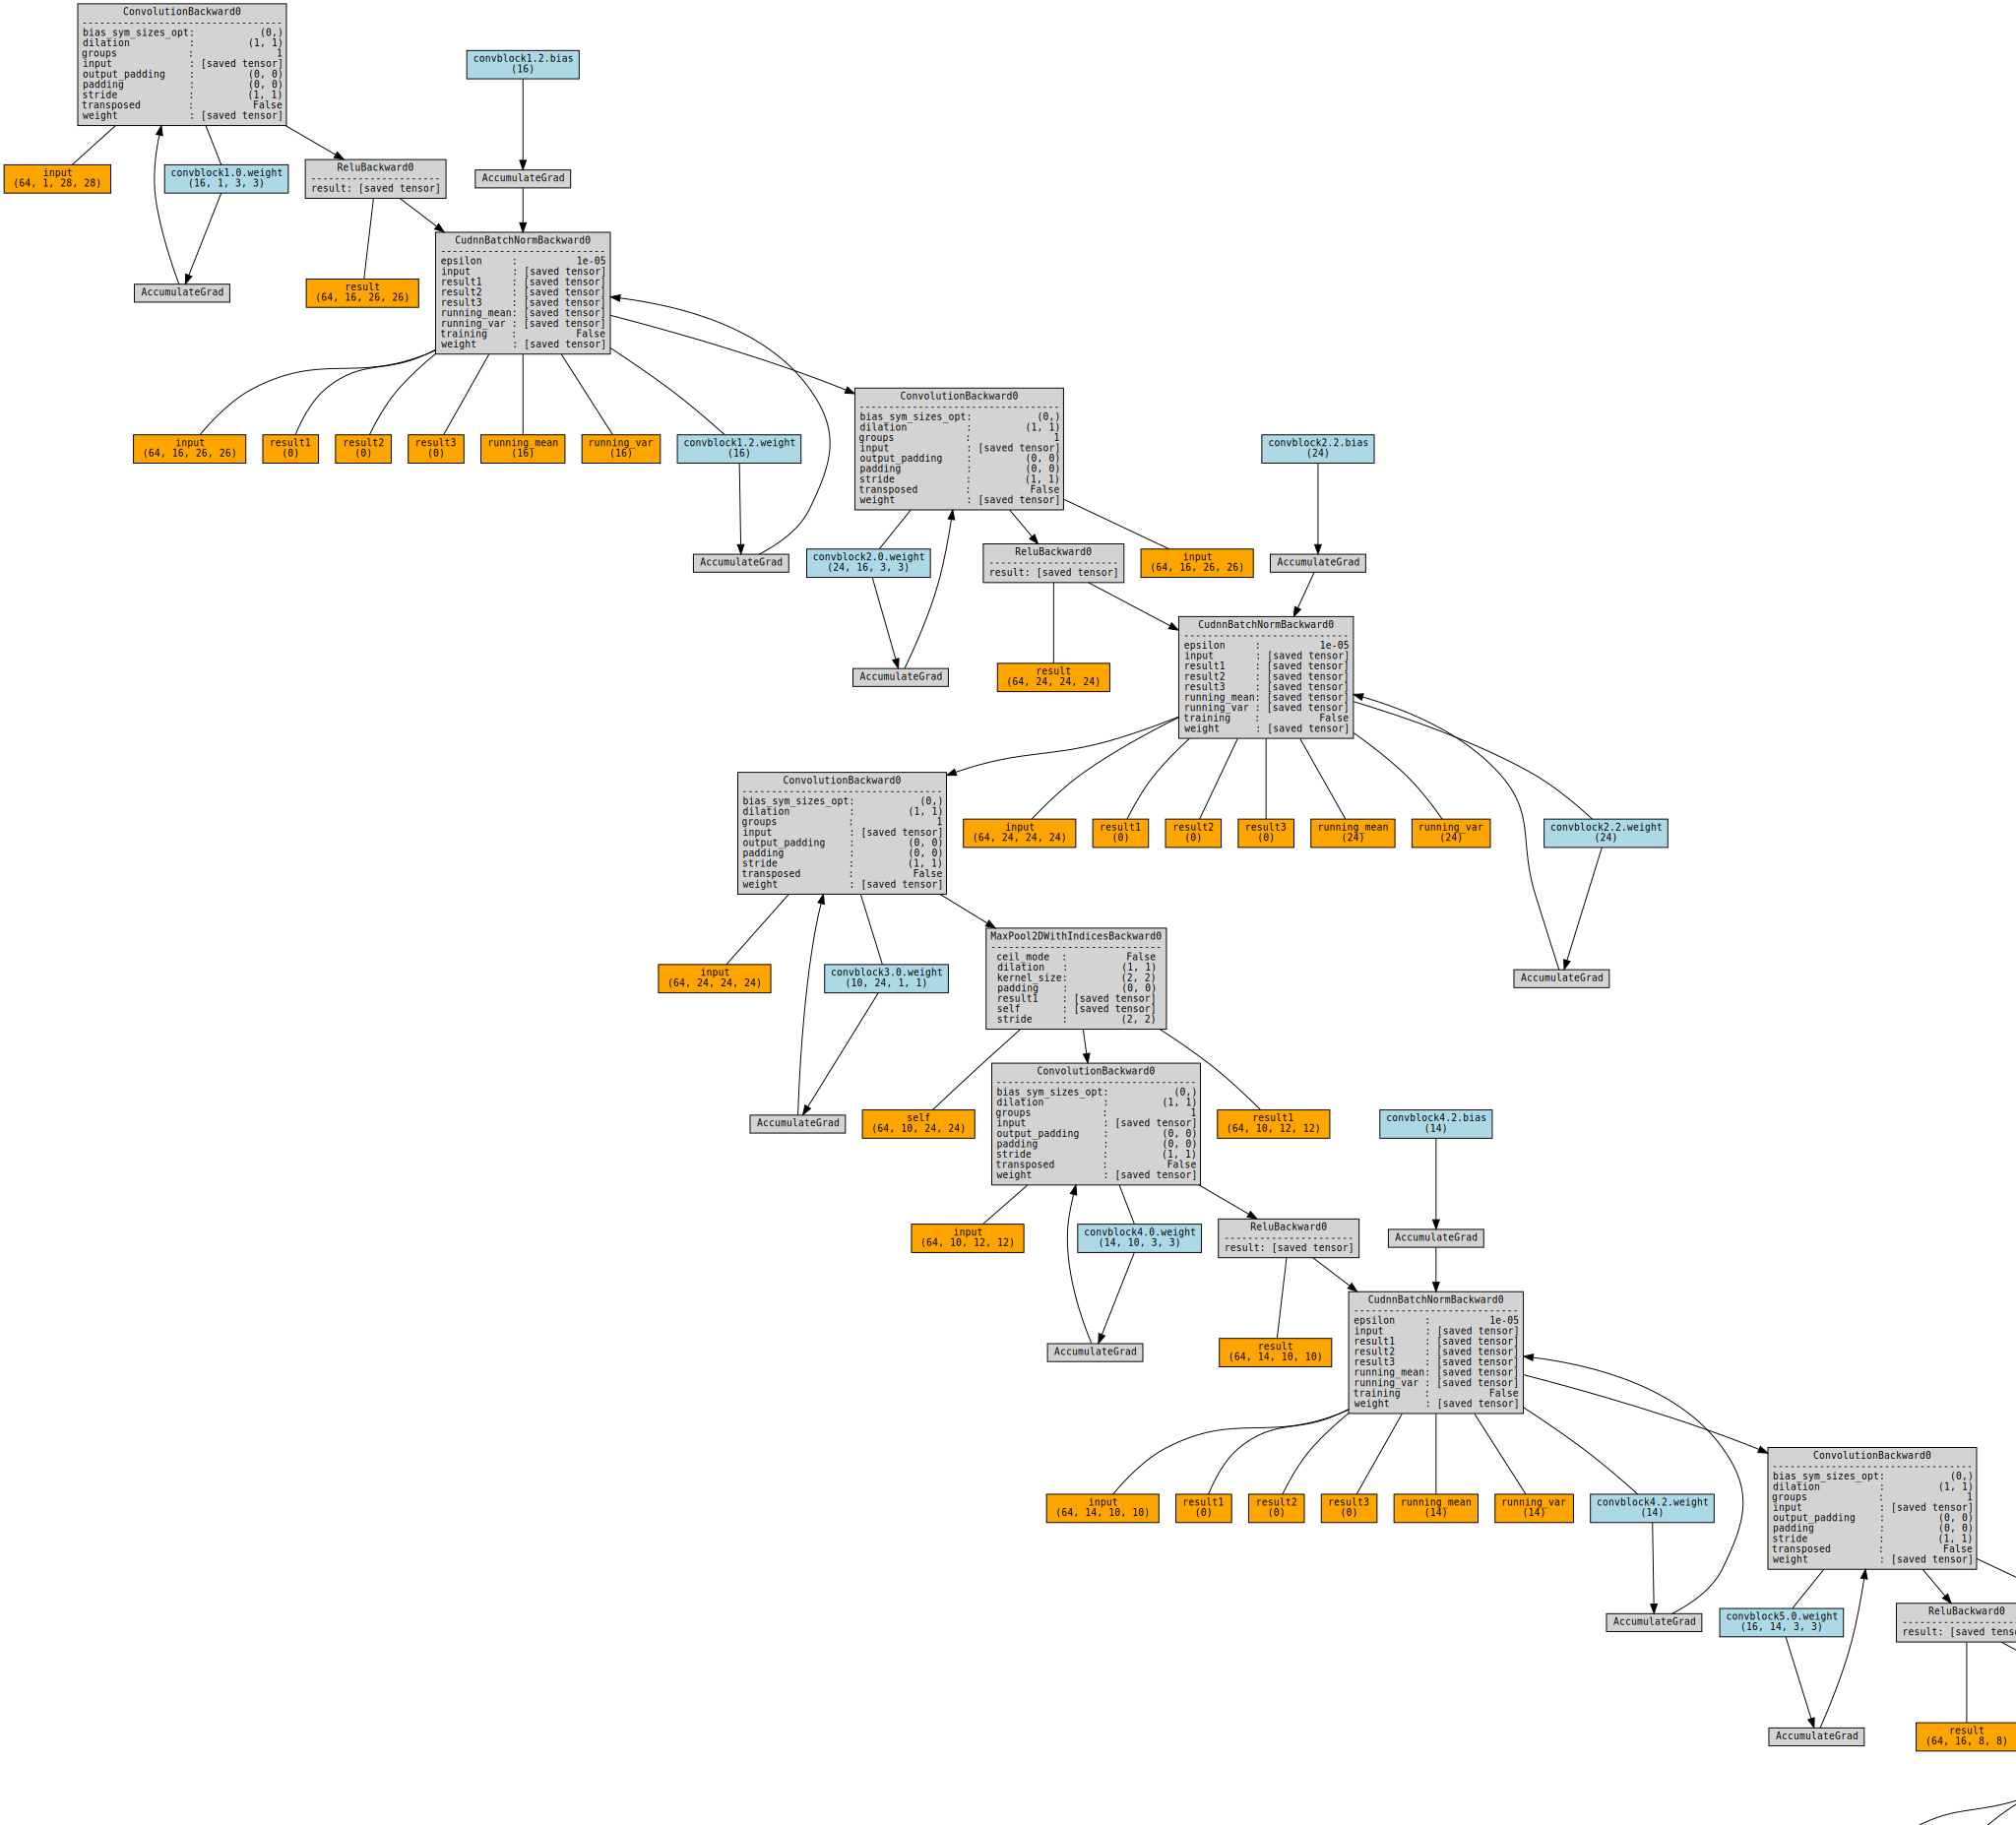

In [18]:
batch_data, batch_label = next(iter(train_loader))
batch_data = batch_data.to(device)
y = model(batch_data)

make_dot(y, params=dict(list(model.named_parameters())), show_attrs=True, show_saved=True)
# .render("mnist_cnn_torchviz", format="png")

In [19]:
make_dot(y, params=dict(list(model.named_parameters())), show_attrs=True, show_saved=True).render("mnist_cnn_torchviz", format="png")

'mnist_cnn_torchviz.png'